# BA820 Project – Milestone 2: Early Analysis & Insights

**Student:** Zixiao Jiao

**Focus**: Palette archetypes and perceived stylistic consistency in Bob Ross paintings

This notebook presents my individual exploratory analysis for Milestone 2 of the BA820 project. Rather than aiming for definitive conclusions, the purpose of this work is to investigate whether the strong visual consistency often associated with Bob Ross paintings reflects the presence of a small number of recurring palette structures, or whether this consistency is largely an illusion created by frequent reuse of individual pigments. The analysis focuses on identifying early structural patterns, similarities, and limitations that help refine the initial assumptions proposed in the project proposal.


## 1. Focus of This Milestone

In this milestone, I focus on exploring whether the visual consistency commonly associated with Bob Ross paintings reflects the presence of a small number of recurring palette structures, or whether color usage varies more continuously across works. Rather than assuming stylistic uniformity, this analysis takes an exploratory, unsupervised approach to examine similarity and structure in pigment usage.

This Milestone 2 question is an extension of my Milestone 1 exploration rather than a completely new topic. In M1, I observed strong overlap in pigment usage across paintings, which raised a natural follow-up: is there a small set of recurring palette “types,” or is the perceived consistency mainly driven by repeated use of a shared core palette?

So the core idea did not change, but the focus became more specific. Instead of trying to describe the dataset broadly, I use M2 to test whether meaningful palette-based structure actually emerges under an unsupervised similarity framework.

## 2. EDA and Preprocessing Updates



The dataset was examined to understand how pigment usage is represented across paintings. Each painting is described by a set of pigment indicators, which naturally lends itself to a binary representation (used vs. not used).

All pigment columns were converted to boolean values to ensure consistency and to support similarity-based and unsupervised analyses. Aside from this standardization, no additional filtering or feature engineering was performed, as preserving the original palette structure was important for the exploratory goals of this milestone.


### 2.1 Data Preparation and Binary Palette Representation

In [4]:
import pandas as pd
df = pd.read_csv("bob_ross.csv")
print(df.shape)
df.head()

(403, 27)


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [5]:
import pandas as pd
import numpy as np

non_color_cols = {
    "painting_index","img_src","painting_title","season","episode",
    "num_colors","youtube_src","colors","color_hex"
}
color_cols = [c for c in df.columns if c not in non_color_cols]

def to_bool(s: pd.Series) -> pd.Series:
    if s.dtype == bool:
        return s
    return (s.astype(str).str.upper()
            .map({"TRUE": True, "FALSE": False, "1": True, "0": False})
            .fillna(False).astype(bool))

X = df[color_cols].apply(to_bool).astype(int)

print("Num paintings:", len(df))
print("Num pigments:", len(color_cols))
print("X shape:", X.shape)
print("Unique values in X:", np.unique(X.values))

Num paintings: 403
Num pigments: 18
X shape: (403, 18)
Unique values in X: [0 1]


In this step, I separated pigment-related columns from metadata such as titles and episode information. Since the goal is to study whether a color was used rather than how often it was used, all pigment variables were converted into binary indicators. This makes palette comparisons across paintings more consistent and interpretable.

## 3. Analysis & Experiments

### 3.1 Pairwise Similarity Using Jaccard Distance

In [7]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X.astype(bool).to_numpy(), metric="jaccard")
overall_mean_dist = D[np.triu_indices_from(D, k=1)].mean()
print("Distance matrix shape:", D.shape)
print("Overall mean Jaccard distance:", overall_mean_dist)

Distance matrix shape: (403, 403)
Overall mean Jaccard distance: 0.36538496737070536


To measure how similar two paintings are in terms of color usage, I computed the Jaccard distance between their binary palettes. This metric focuses on shared versus non-shared colors, which fits the structure of the data well. The overall average distance provides a baseline for how similar Bob Ross paintings are, on average.

### 3.2 Hierarchical Clustering of Paintings

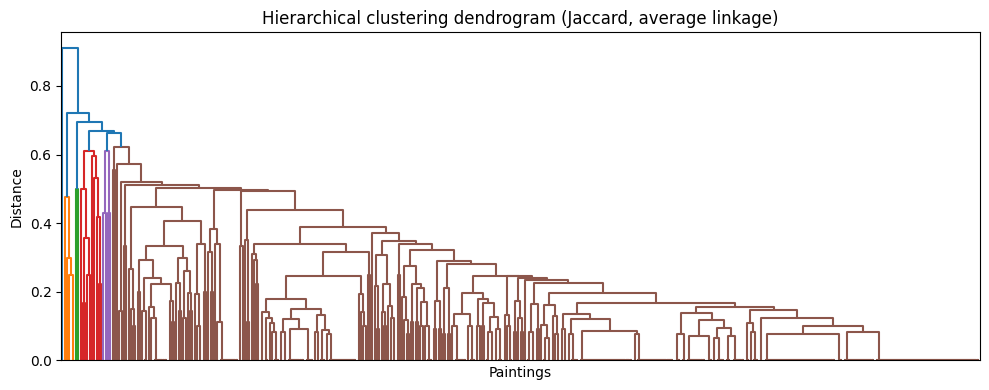

In [8]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(squareform(D, checks=False), method="average")

plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical clustering dendrogram (Jaccard, average linkage)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

Using the Jaccard distance matrix, I applied hierarchical clustering to explore whether paintings naturally group into a small number of palette-based clusters. The dendrogram offers a visual way to assess whether any clear structure exists. Even though the tree is dense, it still provides evidence about relative similarities between paintings.

### 3.3 Cluster-Level Palette Profiles (K = 4 and K = 6)

In [9]:
from scipy.cluster.hierarchy import fcluster

def summarize_clusters(k: int, topn: int = 8):
    clusters = fcluster(Z, t=k, criterion="maxclust")
    df_k = df.copy()
    df_k["cluster"] = clusters

    print(f"\n===== Cluster sizes (K={k}) =====")
    display(df_k["cluster"].value_counts().sort_index().rename("count").to_frame())

    X_tmp = X.copy()
    X_tmp["cluster"] = clusters
    profiles = X_tmp.groupby("cluster")[color_cols].mean()

    for c in sorted(np.unique(clusters)):
        top_colors = profiles.loc[c].sort_values(ascending=False).head(topn)
        print(f"\nCluster {c} (n={int((clusters==c).sum())}) — top pigments")
        display(top_colors)

    return clusters

clusters_k4 = summarize_clusters(4)
clusters_k6 = summarize_clusters(6)


===== Cluster sizes (K=4) =====


,count
cluster,
1,5
2,2
3,395
4,1



Cluster 1 (n=5) — top pigments


,1
Van_Dyke_Brown,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Alizarin_Crimson,0.4
Liquid_Black,0.2
Black_Gesso,0.2
Indian_Yellow,0.2
Bright_Red,0.0



Cluster 2 (n=2) — top pigments


,2
Bright_Red,1.0
Burnt_Umber,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Black_Gesso,0.5
Cadmium_Yellow,0.5
Midnight_Black,0.5
Indian_Yellow,0.5



Cluster 3 (n=395) — top pigments


,3
Titanium_White,0.994937
Alizarin_Crimson,0.956962
Van_Dyke_Brown,0.924051
Cadmium_Yellow,0.873418
Yellow_Ochre,0.827848
Phthalo_Blue,0.817722
Bright_Red,0.807595
Midnight_Black,0.800000



Cluster 4 (n=1) — top pigments


,4
Van_Dyke_Brown,1.0
Black_Gesso,0.0
Bright_Red,0.0
Burnt_Umber,0.0
Dark_Sienna,0.0
Cadmium_Yellow,0.0
Indian_Yellow,0.0
Liquid_Black,0.0



===== Cluster sizes (K=6) =====


,count
cluster,
1,5
2,2
3,10
4,4
5,381
6,1



Cluster 1 (n=5) — top pigments


,1
Van_Dyke_Brown,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Alizarin_Crimson,0.4
Liquid_Black,0.2
Black_Gesso,0.2
Indian_Yellow,0.2
Bright_Red,0.0



Cluster 2 (n=2) — top pigments


,2
Bright_Red,1.0
Burnt_Umber,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Black_Gesso,0.5
Cadmium_Yellow,0.5
Midnight_Black,0.5
Indian_Yellow,0.5



Cluster 3 (n=10) — top pigments


,3
Prussian_Blue,0.9
Titanium_White,0.9
Midnight_Black,0.8
Alizarin_Crimson,0.6
Phthalo_Blue,0.6
Black_Gesso,0.5
Sap_Green,0.5
Liquid_Clear,0.3



Cluster 4 (n=4) — top pigments


,4
Alizarin_Crimson,1.00
Titanium_White,1.00
Phthalo_Blue,1.00
Phthalo_Green,0.50
Van_Dyke_Brown,0.50
Sap_Green,0.25
Indian_Yellow,0.25
Burnt_Umber,0.25



Cluster 5 (n=381) — top pigments


,5
Titanium_White,0.997375
Alizarin_Crimson,0.965879
Van_Dyke_Brown,0.952756
Cadmium_Yellow,0.900262
Yellow_Ochre,0.858268
Bright_Red,0.834646
Phthalo_Blue,0.821522
Midnight_Black,0.808399



Cluster 6 (n=1) — top pigments


,6
Van_Dyke_Brown,1.0
Black_Gesso,0.0
Bright_Red,0.0
Burnt_Umber,0.0
Dark_Sienna,0.0
Cadmium_Yellow,0.0
Indian_Yellow,0.0
Liquid_Black,0.0


After forming clusters, I summarized each cluster by its average pigment usage rates. This helps reveal which colors tend to define each group and whether clusters correspond to distinct palette patterns. Comparing different values of K allows for a more flexible, exploratory interpretation rather than committing to a single solution.

### 3.4 Within-Cluster Distance vs. Overall Baseline

I examined K = 4 and K = 6 to contrast coarse- and finer-grained clusterings, and to check whether increasing K reveals more stable or clearly differentiated palette patterns.


Overall mean Jaccard distance: 0.36538496737070536

=== K=4 diagnostic ===


,cluster,n,within_mean_dist,within_minus_overall
0,1,5,0.330476,-0.034909
2,3,395,0.350142,-0.015243
1,2,2,0.500000,0.134615


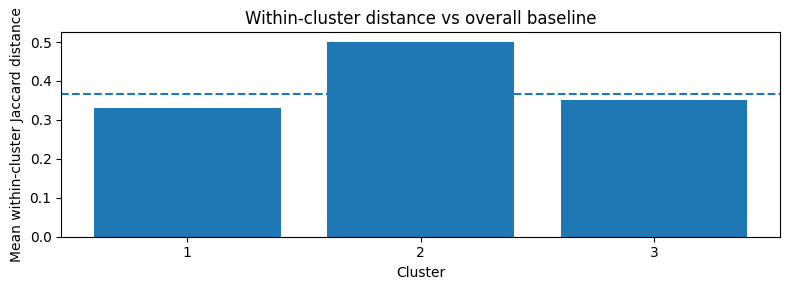


=== K=6 diagnostic ===


,cluster,n,within_mean_dist,within_minus_overall
4,5,381,0.326451,-0.038934
0,1,5,0.330476,-0.034909
1,2,2,0.500000,0.134615
2,3,10,0.537116,0.171731
3,4,4,0.549206,0.183821


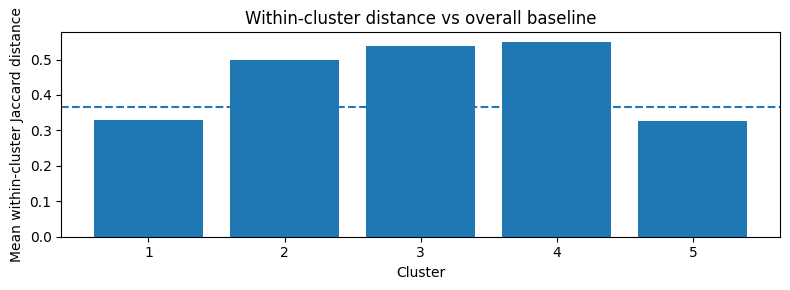

In [10]:
import pandas as pd

def within_vs_overall(clusters):
    rows = []
    for c in sorted(np.unique(clusters)):
        idx = np.where(clusters == c)[0]
        if len(idx) < 2:
            continue
        Dc = D[np.ix_(idx, idx)]
        within_mean = Dc[np.triu_indices_from(Dc, k=1)].mean()
        rows.append([c, len(idx), within_mean, within_mean - overall_mean_dist])

    res = pd.DataFrame(rows, columns=["cluster","n","within_mean_dist","within_minus_overall"])
    display(res.sort_values("within_mean_dist"))

    plt.figure(figsize=(8, 3))
    plt.bar(res["cluster"].astype(str), res["within_mean_dist"])
    plt.axhline(overall_mean_dist, linestyle="--")
    plt.xlabel("Cluster")
    plt.ylabel("Mean within-cluster Jaccard distance")
    plt.title("Within-cluster distance vs overall baseline")
    plt.tight_layout()
    plt.show()

print("Overall mean Jaccard distance:", overall_mean_dist)

print("\n=== K=4 diagnostic ===")
within_vs_overall(clusters_k4)

print("\n=== K=6 diagnostic ===")
within_vs_overall(clusters_k6)

To evaluate whether the clusters meaningfully group similar paintings, I compared the average within-cluster Jaccard distance to the overall average distance. If a cluster’s internal distance is lower than the global baseline, it suggests that paintings within that cluster are more similar to each other than expected. This provides a simple diagnostic for whether the clustering adds structure beyond random variation.

### 3.5 Linkage Method Sensitivity Check

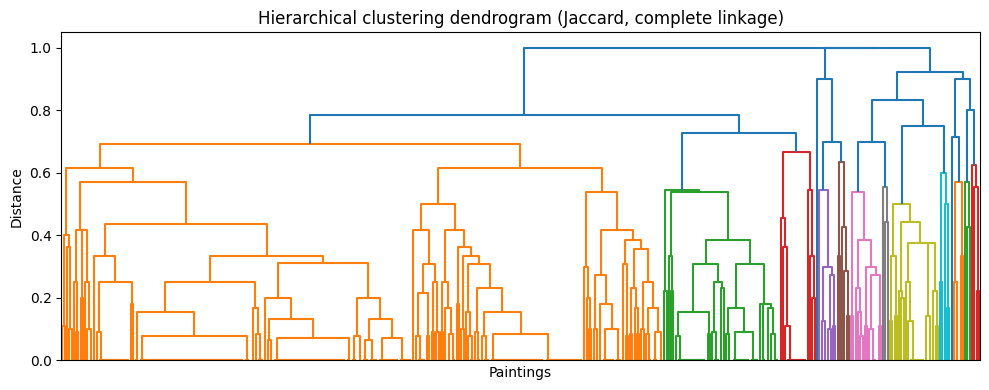

In [11]:
from scipy.cluster.hierarchy import linkage

Z_complete = linkage(squareform(D, checks=False), method="complete")

plt.figure(figsize=(10, 4))
dendrogram(Z_complete, no_labels=True)
plt.title("Hierarchical clustering dendrogram (Jaccard, complete linkage)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In this step, I repeated the clustering using complete linkage instead of average linkage. This allows me to see whether the main similarity patterns remain consistent across different clustering choices.

### 3.6 Sensitivity Check: Excluding Titanium White

In [12]:
print([c for c in color_cols if "WHITE" in c.upper()])

['Titanium_White']


Overall mean Jaccard distance (without Titanium White): 0.39509025629123035


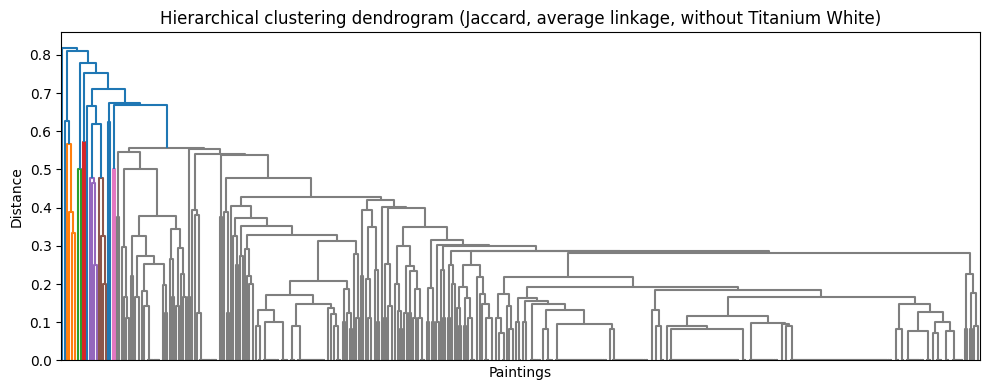

In [13]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import matplotlib.pyplot as plt

tw_col = "Titanium_White"

color_cols_no_tw = [c for c in color_cols if c != tw_col]

X_no_tw = df[color_cols_no_tw].apply(to_bool).astype(bool).to_numpy()

D_no_tw = pairwise_distances(X_no_tw, metric="jaccard")
overall_mean_dist_no_tw = D_no_tw[np.triu_indices_from(D_no_tw, k=1)].mean()

print("Overall mean Jaccard distance (without Titanium White):", overall_mean_dist_no_tw)


Z_no_tw = linkage(squareform(D_no_tw, checks=False), method="average")

plt.figure(figsize=(10, 4))
dendrogram(Z_no_tw, no_labels=True)
plt.title("Hierarchical clustering dendrogram (Jaccard, average linkage, without Titanium White)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

After removing Titanium White, the average Jaccard distance increases, indicating that this near-universal pigment does contribute to overall similarity. However, the dendrogram remains structurally similar, suggesting that the lack of clear palette-based clusters cannot be explained by Titanium White alone. Instead, variation in color usage appears to be gradual rather than driven by a small number of distinct palette archetypes.

## 4. Key Findings & Interpretations
From a practical perspective, our results suggest that hard clustering may not be the most informative strategy for palette data in this setting. Instead of forcing paintings into a small number of discrete styles, it may be more useful to focus on similarity-based analysis, such as nearest-neighbor retrieval and identifying outliers that deviate from the majority. Overall, the patterns we observe are more consistent with the idea that Bob Ross’s perceived consistency comes from shared base pigments plus gradual variation, rather than clearly separable palette archetypes.


## 5. Challenges, Dead Ends, and Adjustments

A key challenge in this analysis was the absence of clear cluster separation. To ensure this result was not driven by modeling choices or by near-universal pigments, I conducted simple sensitivity checks by changing the linkage method and excluding Titanium White.

These adjustments did not materially alter the clustering patterns. This suggests that the lack of distinct palette-based clusters reflects the underlying structure of the data rather than an artifact of a specific analytical choice.

## 6. Next Steps & Continuity
At this stage, clustering stability has not been formally quantified, so robustness remains an open issue. Given the weak evidence for hard clusters, a similarity network view or explicit outlier detection may be more informative than additional clustering. An open question is whether semantic themes in painting titles align with palette similarity, which could introduce structure not visible in color usage alone. Overall, these findings suggest shifting the focus from identifying discrete clusters to modeling continuous similarity patterns and highlighting meaningful deviations.
